SABR model, stochastic $\alpha$, $\beta$, $\rho$:
$$
\begin{aligned}
    &dF_t = \alpha_t F_t^{\beta} dW_t^1 \\
    &d\alpha_t = \nu \alpha_t dW_t^2 \\
    & dW_t^1 dW_t^2 = \rho dt
\end{aligned}
$$
$\alpha_t$ is geometrical brownian motion, so we have:
$$
\alpha_t = \alpha_0 \exp( -0.5 \nu^2 t + \nu W_t^2 )
$$
It is natural to introduce new variable $y_t$ as:
$$
y_t = \ln \alpha_t.
$$ For $y_t$ we have the following SDE:
$$
d y_t = -0.5 \nu^2 dt + \nu
dW_t^2
$$

Let us consider the following change of variable for $F_t$:
$$
X_t = F_t^{-\beta+1}
$$Then:
$$
dX_t = (-\beta + 1) F_t^{-\beta} dF_t + 0.5 (-\beta+1) (-\beta) F_t^{-\beta-1} (dF_t)^2 = 
    (-\beta + 1)\alpha_t dW_t^1 + \alpha_t^2 \dfrac{\beta (\beta - 1)}{2 X_t}dt
$$

Another intresting choise is:
$$
X_t = \log \left( {F_t} \right) 
$$

$$
dX_t = \dfrac{dF_t}{F_t} - \dfrac{1}{2}\dfrac{(dF_t)^2}{F_t^2} = \alpha_t F_t^{\beta - 1} dW_t^1 - \dfrac{1}{2}\alpha_t^2 F_t^{2(\beta - 1)}dt = 
\alpha_t \exp(X_t (\beta - 1)) dW_t^1 - \dfrac{1}{2}\alpha_t^2 \exp(2 X_t (\beta - 1))dt
$$

Consider $X_t \to (\beta - 1) X_t$:
$$
dX_t = (\beta-1) \alpha_t \exp(X_t) dW_t^1 - \dfrac{(\beta-1)\alpha_t^2}{2} \exp(2 X_t)dt
= (\beta-1)\exp(y_t + X_t) dW_t^1 - \dfrac{(\beta-1)}{2} \exp(2 (X_t+y_t))dt
$$

So, for the price $V(x, y, t)$ of an option with payoff function $g(F_T)$, in the first case $x=F^{-\beta+1}$ we have following PDE:
$$
    V_t + e^{2 y} \dfrac{\beta (\beta - 1)}{2 x} V_x - \dfrac{\nu^2}{2} V_y + \dfrac{(-\beta + 1)^2}{2}e^{2y} V_{xx}
    + \dfrac{\nu^2}{2} V_{yy} + \nu \rho (-\beta + 1) e^{2y} V_{xy} = rV
$$

$$
\begin{aligned}
    &\mu_x = e^{2 y} \dfrac{\beta (\beta - 1)}{2 x}\\
    &\mu_y =  - \dfrac{\nu^2}{2}\\
    &\sigma_x = \dfrac{(-\beta + 1)^2}{2}e^{2y} \\
    &\sigma_y =  \dfrac{\nu^2}{2} V_{yy}\
    &\sigma_{xy} = \nu \rho (-\beta + 1) e^{2y}
\end{aligned}
$$
In the second case $x = (\beta-1) F$:

$$
    V_t - \dfrac{(\beta-1) e^{2(x+y)}}{2}V_x - \dfrac{\nu^2}{2} V_y + \dfrac{(\beta - 1)^2}{2}e^{2y+2x} V_{xx}
    + \dfrac{\nu^2}{2} V_{yy} + \nu \rho (-\beta + 1) e^{2(x+y)} V_{xy} = rV
$$

In [1]:
import sys
sys.path.append('../heston')

In [2]:
from montecarlo import *
from heston import *
from solver import *

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats as sps

In [4]:
from numba import njit

In [5]:
def GetBrownianMotion(tn, Npaths):
    n = len(tn)
    
    W = np.zeros((n, Npaths))
    eps = np.random.randn(n-1, Npaths)
    
    W[1:, :] = np.cumsum(eps, axis=0) * np.sqrt(np.diff(tn).reshape(-1, 1))
    return W


def GetAlpha(tn, Npaths, alpha0, nu):
    W = GetBrownianMotion(tn, Npaths)
    return alpha0 * np.exp( -0.5 * nu**2 * tn.reshape(-1, 1) + nu * W)


def genAntipath(Npaths):
    eps = np.random.randn(Npaths // 2)
    return np.r_[eps, -eps]

def SimulateSABR(tn, Npaths, alpha0, nu, F0, beta, rho):
    X = F0 ** (-beta + 1) * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY
     
        b = -(X + (-beta + 1) * np.exp(y) * dW)
        c = -np.exp(2 * y) * beta * (beta - 1) / 2 * dt
        D = b ** 2 - 4 * c
        D = np.maximum(D, 0.0)
        X = 0.5 * (-b + np.sqrt(D))
        X = np.maximum(X, 0.0)
        
        y += -0.5 * nu ** 2 * dt + nu * dZ
        
    F = (X + 1e-10) ** (1 / (-beta + 1))
    return F

In [6]:
def SimulateSABRLog(tn, Npaths, alpha0, nu, F0, beta, rho):
    
    X = (beta - 1) * np.log(F0) * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY
        
        
        
        X += -0.5 * (beta - 1) * np.exp(2 * (X + y) ) * dt + (beta - 1) * np.exp(X + y) * dW 
        
        y += -0.5 * nu ** 2 * dt + nu * dZ
    F = np.exp(X / (beta - 1))
    return F


def SimulateSABREuler(tn, Npaths, alpha0, nu, F0, beta, rho):
    F = F0 * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY

        F += dW * np.exp(y) * (F ** beta)
        F = np.maximum(F, 0.0)
        
        y += -0.5 * (nu ** 2) * dt + nu * dZ
    return F


def SimulateSABREulerModified(tn, Npaths, alpha0, nu, F0, beta, rho):
    F = F0 * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY

        F += dW * np.exp(y) * (F ** beta) + 0.5 * beta * np.exp(2 * y) * F ** (2 * beta - 1) * (dW **2 - dt)
        y += -0.5 * (nu ** 2) * dt + nu * dZ
        
        F = np.maximum(F, 0.0)
    return F

In [7]:
def IntegralVarSampling(Npaths, alp0, nu, dt):
    W = genAntipath(Npaths) * np.sqrt(dt)
    alpha = alp0 * np.exp( nu * W - 0.5 * nu ** 2 * dt)
    
    m = (alp0 ** 2) * dt * ( 1 + nu * W + (1.0/3.0) * (nu ** 2) * (2 * W**2 - dt / 2) * \
                           (1.0/3.0) * (nu ** 3) * (W**3 - W * dt) + \
                           (1.0/5.0) * (nu ** 4) * ((2.0/3.0) * W ** 4 - (3.0/2.0) * W**2 * dt + 2 * dt ** 2) )
    v = (1.0/3.0) * (alp0 ** 4) * (nu ** 2) * (dt ** 3)
    
    mu = np.log(m) - 0.5 * np.log(1 + v / m ** 2)
    sig = np.sqrt(np.log(1 + v / m ** 2))
    
    U = genAntipath(Npaths)
    A = np.exp(sig * U + mu)
    
    return alpha, A


def DirectInversionScheme(tn, Npaths, alpha0, nu, F0, beta, rho):
    
    dt = tn[-1] - tn[0]
    
    alpha, A = IntegralVarSampling(Npaths, alpha0, nu, dt)
    
    v = (1 - rho ** 2) * A
    
    a = 1 / v * ( F0 ** (1 - beta) / (1 - beta) + rho / nu * (alpha - alpha0) ) ** 2
    b = 2 - (1 - 2 * beta - rho ** 2 * (1 - beta)) / (1 - beta) / (1 - rho ** 2)
    F = np.random.noncentral_chisquare(b, a, Npaths)
    
    k = 2 - b
    lam = a
    
    m = k + lam
    s = np.sqrt(2 * (k + 2 * lam))
    
    psi = s ** 2 / m ** 2
    
    e = np.sqrt( 2 / psi - 1 + np.sqrt(2/psi) * np.sqrt(2/psi - 1) )
    
    d = m / (1 + e ** 2)
    
    Z = np.random.randn(Npaths)
    Y = d * (e + Z) ** 2
    F = ((1-beta) ** 2 * v * Y) ** (1 / (2 - 2 * beta))
    return F

In [8]:
def BC(K, F, r, tau, vol):
    d1 = (np.log(F / K) + 0.5 * vol ** 2 * tau) \
                / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    
    D = np.exp(-r * tau)
    call_price =  D *  ( F * sps.norm.cdf(d1) - K * sps.norm.cdf(d2) )
    return call_price

In [9]:
def SabrApprox(K, F, r, tau, alpha, beta, rho, nu):
    
    #this function has problems if F = K.
    #need to think, how to fix this
   
    Fmid = np.sqrt( F * K )
    C = lambda _x : _x ** beta
    
    dzeta = nu / (alpha * (1-beta)) * ( F ** (1-beta) - K ** (1-beta) )
    
    gamma1 = beta / Fmid
    gamma2 = -beta * (1 - beta) / Fmid**2
    D = np.log( (  np.sqrt(1 - 2 * rho * dzeta + dzeta ** 2) + dzeta - rho  ) / (1-rho) )
    eps = tau * nu ** 2
    
    frc1 = (2 * gamma2 - gamma1**2+1/Fmid**2) / 24 * (alpha / nu * C(Fmid)) ** 2
    
    frc2 = rho * gamma1 / (4 * nu) * alpha * C(Fmid)
    
    frc3 = (2-3*rho**2)/24 
    
    vol = nu * np.log(F / K) / D * (1 + eps * (frc1 + frc2 + frc3) )
    
    call_price =  BC(K, F, r, tau, vol)
    return call_price, vol

In [10]:
from scipy.optimize import root_scalar

In [31]:
def get_iv(call_prices, Ks, F, r, tau):
    
    res = []
    for call_price, K in zip(call_prices, Ks):
        def foo(vol):
            call_price_ = BC(K, F, r, tau, vol)
            return call_price_ - call_price
 
        v0 = 1e-15
        v1 = 100
        
        br = foo(v0) <= 0 and foo(v1) >= 0
        vol = np.nan
        if not br:
            if foo(v0) > 1e-10:
                vol = 0.0
            elif foo(v1) < 1e-10:
                vol = np.nan
        else:
            vol = root_scalar(foo, bracket=[v0, v1], method='bisect').root
        res.append( vol )
    return np.asarray(res)

In [136]:
Npaths = 100000
Nt = 1000

In [224]:
F0 = 0.1

beta = 0.7

rho = 0.25

r = 0.0

T = 5.5

nu = 0.15
alpha0 = 0.3

tn = T * np.linspace(0, 1, Nt)

In [225]:
F = SimulateSABR(tn, Npaths, alpha0, nu, F0, beta, rho)

In [226]:
K = np.linspace(0.1 * F0, 5.0 * F0, 101)

In [227]:
payoff = np.maximum(F.reshape(-1, 1) - K.reshape(1, -1), 0.0)

In [228]:
C = np.mean(payoff, axis=0)

In [229]:
C1, vol = SabrApprox(K, F0, r, tn[-1], alpha0, beta, rho, nu)

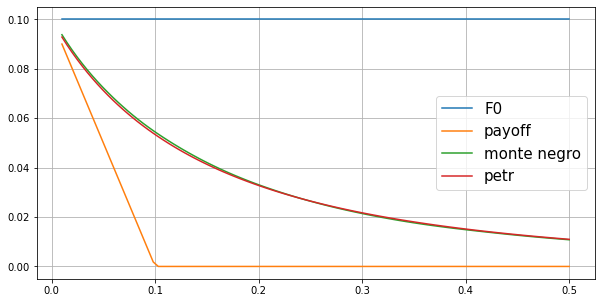

In [230]:
plt.figure(figsize=(10, 5))
plt.plot(K, F0 * np.ones((len(K), 1)), label='F0')
plt.plot(K, np.maximum(F0 - K, 0.0), label='payoff')
plt.plot(K, C, label='monte negro')
plt.plot(K, C1, label='petr')
plt.legend(fontsize=15)
plt.grid()

In [231]:
iv = get_iv(C, K, F0, r, T)
iv_1 = get_iv(C1, K, F0, r, T)

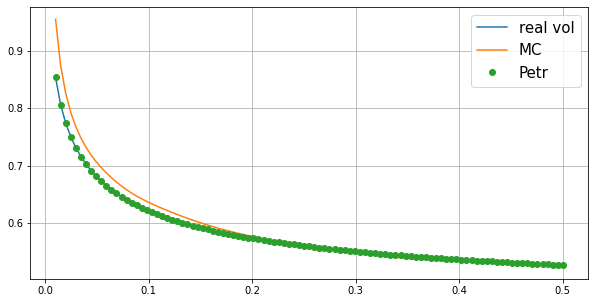

In [232]:
plt.figure(figsize=(10, 5))
plt.plot(K, vol, label='real vol')
plt.plot(K, iv, label='MC')
plt.plot(K, np.clip(iv_1, 0, 1), 'o', label='Petr')
plt.legend(fontsize=15)
plt.grid()

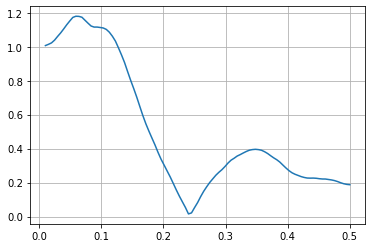

In [233]:
plt.plot(K, np.abs(C - C1) / np.max(np.abs(C)) * 100)
plt.grid()

In [202]:
K = F0

In [203]:
Fmax = 5 * F0
Fmin = 0.05 * F0

In [204]:
def gridX(Nx):
    
    Fn = np.linspace(Fmin, Fmax, Nx + 1)
    xn = np.sort(Fn ** (-beta + 1))
    hx = np.diff(xn)
    return xn, hx

def gridY(Ny):
    yn = np.linspace(-2, 2, Ny + 1) + np.log(alpha0)
    hy = np.diff(yn)
    return yn, hy

def gridT(Nt):
    return T * np.linspace(0, 1.0, Nt + 1)

In [205]:
Nx = 151
Ny = 20
Nt = 10

In [206]:
Xleft = Neuman(lambda x: 0.0)

Xright = Dirichle(lambda x: Fmax - K)

Yleft = Neuman(lambda x: 0.0)

Yright = Neuman(lambda x: 0.0)

boundary = Boundary2D(Xleft, Xright, Yleft, Yright)

init = lambda x, y: np.maximum(0, x ** (1 / (1 - beta)) - K)


mux = lambda x, y: np.exp(2 * y) * beta * (beta - 1) / (2 * x)
muy = lambda x, y: - nu**2 / 2

sigmax = lambda x, y: 0.5 * (beta-1) ** 2 * np.exp(2 * y)
sigmay = lambda x, y: 0.5 * nu ** 2
sigmaxy = lambda x, y: nu * rho * (-beta + 1) * np.exp(2 * y)

problem = Problem(boundary, init, mux, muy, sigmax, sigmay, sigmaxy)

der = DerCntrl()

In [207]:
xn, _ = gridX(Nx)

Fn = xn ** (1 / (1 - beta))

In [208]:
solverHV = ADI_CS(problem, der, gridX, gridY, gridT)

In [209]:
uHV = solverHV.solve(Nx, Ny, Nt)

In [210]:
C_finite = uHV[-1, :-Nx // 4, Ny // 2 ]

In [211]:
Fn = Fn[:-Nx // 4]

In [212]:
C1, vol = SabrApprox(K, Fn, r, tn[-1], alpha0, beta, rho, nu)

In [213]:
Npaths = 5000

In [214]:
alpha0

0.3

In [215]:
yn, _ = gridY(Ny)

In [216]:
np.exp(yn[Ny // 2])

0.3

In [217]:
Cmonte = []
for f in Fn:
    F = SimulateSABR(tn, Npaths, alpha0, nu, f, beta, rho)
    Cmonte.append( np.mean( np.maximum(F - K, 0) ) )
Cmonte = np.asarray(Cmonte)

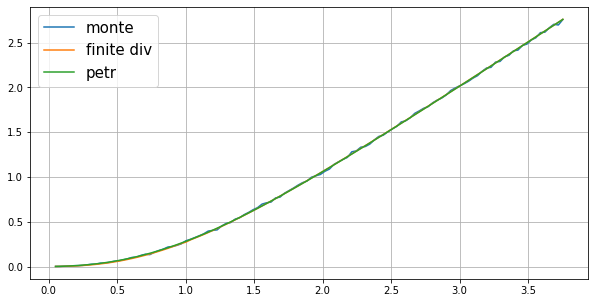

In [218]:
plt.figure(figsize=(10, 5))
plt.plot(Fn, Cmonte, label= "monte")
plt.plot(Fn, C_finite,  label="finite div")
plt.plot(Fn, C1, label="petr")
plt.legend(fontsize=15)
plt.grid()

In [219]:
np.linalg.norm(Cmonte - C_finite) / np.linalg.norm(Cmonte) * 100

0.6704272450362325

In [220]:
np.linalg.norm(C1 - C_finite) / np.linalg.norm(C1) * 100

0.24891161334192013

In [221]:
def monteGAqweqwd(rho):
    Cmonte = []
    for f in Fn:
        F = SimulateSABREuler(tn, Npaths, alpha0, nu, f, beta, rho)
        Cmonte.append( np.mean( np.maximum(F - K, 0) ) )
    return np.asarray(Cmonte)

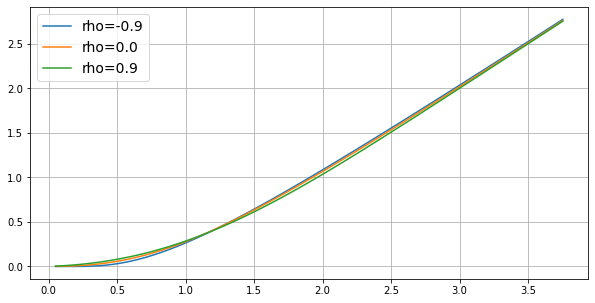

In [222]:
plt.figure(figsize=(10, 5))
for rho in [-0.9, 0.0, 0.9]:
    C1, vol = SabrApprox(K, Fn, r, tn[-1], alpha0, beta, rho, nu)
    plt.plot(Fn, C1, label=f'rho={rho}')
plt.grid()
plt.legend(fontsize=14)
None

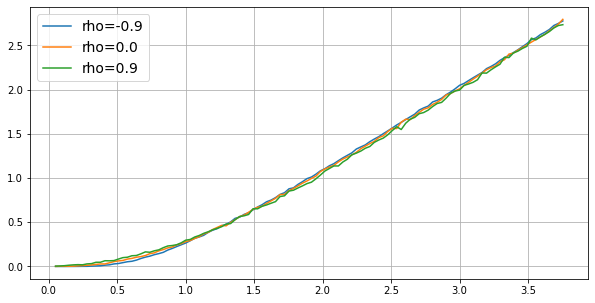

In [223]:
plt.figure(figsize=(10, 5))
for rho in [-0.9, 0.0, 0.9]:
    C1 = monteGAqweqwd(rho)
    plt.plot(Fn, C1, label=f'rho={rho}')
plt.grid()
plt.legend(fontsize=14)
None